# Install

In [1]:
!pip install livelossplot

# Setup

In [2]:
from torch.utils.data import Dataset

import torch
import pickle
import os
import pandas as pd
import numpy as np
import traceback
from pathlib import Path
from livelossplot import PlotLossesKeras

# You are not allowed to use DataLoader, torch.nn, torch.functional, torchvision
# Backpropagation and data preprocessing must be implemented from scratch
# Check https://github.com/Tensor-Reloaded/AI-Learning-Hub/blob/main/how_to/use_kaggle.md for learning how to use kaggle and submit to this competition

# Data aquisition

## Preprocesing functions

In [3]:

def normalization_n1_p1(x):
    return (x/127.5)-1

def normalization_n0_p1(x):
    return x/255

def one_hot(y, num_classes=1):
    #print(y.shape, y)
    tmp = torch.zeros((y.size(0), num_classes), dtype=torch.float32)
    tmp[torch.arange(y.size(0)), y] = 1.0
    return tmp


## Summary function

In [4]:

def test_dataset_fn(img, label):
    info_str = """img: shape {}, min {}, max {}, type {};
label: shape {}, min {}, max {}, type {};""".format(img.shape, torch.min(img), torch.max(img), type(img),
                                           label.shape, torch.min(label), torch.max(label), type(label))
    print(info_str)

## Dataset

In [5]:

class ExtendedMNISTDataset(Dataset):
    def __init__(self, root: str = "/kaggle/input/fii-atnn-2025-competition-1", train: bool = True):
        """ExtendedMNISTDataset:
        root  - path root of dataset
        train - read train or test dataset (true - train, false - test)
        preprocessing - image preprocesing function
        Dataset structure:
            list -> (batchsize, tuple -> (np.array -> (image->(784, )), scalar -> (labels->1)))
        """
        # select filename
        if (train):
            file = "extended_mnist_train.pkl"
        else:
            file = "extended_mnist_test.pkl"
        # join root to filename
        filename = os.path.join(root, file)
        # read dataset
        dataset = self.__read(filename)
        self.inputs, self.outputs = self.__split_data(dataset)

    def __read(self, filename):
        # try to open filename
        try:
            f = open(filename, "rb")
            try:
                dataset = pickle.load(f)
            except Exception as e:
                dataset = None
                self.__show_exception(e)
            finally:
                f.close()
        except IOError as e:
            dataset = None
            self.__show_exception(e)
        return dataset

    def __show_exception(self, e) -> None:
        tb = traceback.extract_tb(e.__traceback__)
        last_call = tb[-1]
        print(f"❌ Error in function '{last_call.name}' at line {last_call.lineno}")
        print(f"   File: {last_call.filename}")
        print(f"   Exception: {e}")

    def __split_data(self, dataset):
        inputs  = []
        outputs = []
        for input, ouput in dataset:
            inputs.append(input)
            outputs.append(ouput)
        return np.array(inputs, dtype=np.uint8), np.array(outputs, dtype=np.int32)

    def __len__(self, ) -> int:
        return self.inputs.shape[0]

    def __getitem__(self, i : int):# int|np array
        return self.inputs[i], self.outputs[i]


In [6]:
#
train_ds = ExtendedMNISTDataset(root="/content", train=True)

❌ Error in function '__read' at line 24
   File: /tmp/ipython-input-965428312.py
   Exception: [Errno 2] No such file or directory: '/content/extended_mnist_train.pkl'


TypeError: 'NoneType' object is not iterable

In [ ]:
train_ds[[0, 1, 2]]

In [ ]:
len(train_ds)

In [ ]:
_, y = train_ds[np.arange(len(train_ds))]

In [ ]:
y.max()

## DataLoader

In [8]:

class DataLoader(object):
    def __init__(self, dataset, batchsize=1, shuffle=False):
        assert (batchsize > 0), "batchsize should be ghreat than 'zero'"
        assert (isinstance(shuffle, bool)), "shuffle should be 'bool'"
        self.dataset = dataset
        self.batchsize = batchsize
        self.shuffle = shuffle
        self.size = len(self.dataset)
        # shufle
        if (self.shuffle):
            self.permutation = np.random.permutation(self.size)
        else:
            self.permutation = np.arange(self.size, dtype=np.int32)
        self.maps_fn = []

    def __len__(self) -> int:
        return len(self.dataset)//self.batchsize

    def __call__(self):
        try:
            for i in range(0, self.size, self.batchsize):
                pos  = self.permutation[i:i+self.batchsize]
                datas = self.dataset[pos]
                if (isinstance(datas, tuple)):
                    datas = [torch.from_numpy(data) for data in datas]
                else:
                    datas = torch.from_numpy(datas)
                datas = self.__map_fn(datas)
                yield datas
            else:
                if (self.shuffle):
                    self.permutation = np.random.permutation(self.size)
        except Exception as e:
            self.__show_exception(e)

    def take(self, size):
        try:
            for i, data in zip(range(size), self()):
                yield data
            else:
                pass
        except Exception as e:
            self.__show_exception(e)

    def __show_exception(self, e) -> None:
        tb = traceback.extract_tb(e.__traceback__)
        last_call = tb[-1]
        print(f"❌ Error in function '{last_call.name}' at line {last_call.lineno}")
        print(f"   File: {last_call.filename}")
        print(f"   Exception: {e}")

    def map(self, fn):
        self.maps_fn.append(fn)

    def __map_fn(self, data):
        for fn in self.maps_fn:
            data = fn(*data)
        return data

In [ ]:
dataloader = DataLoader(train_ds, batchsize=20, shuffle=False)

In [ ]:
dataloader.map(lambda x, y: (normalization_n1_p1(x), one_hot(y, num_classes=10)))
dataloader.map(lambda x, y: (x.unsqueeze(-1), y.unsqueeze(-1)))

In [ ]:
for img, label in dataloader.take(100):
    test_dataset_fn(img, label)
    #print(label)

img: shape torch.Size([20, 784, 1]), min -1.0, max 1.0, type <class 'torch.Tensor'>;
label: shape torch.Size([20, 10, 1]), min 0.0, max 1.0, type <class 'torch.Tensor'>;
img: shape torch.Size([20, 784, 1]), min -1.0, max 1.0, type <class 'torch.Tensor'>;
label: shape torch.Size([20, 10, 1]), min 0.0, max 1.0, type <class 'torch.Tensor'>;
img: shape torch.Size([20, 784, 1]), min -1.0, max 1.0, type <class 'torch.Tensor'>;
label: shape torch.Size([20, 10, 1]), min 0.0, max 1.0, type <class 'torch.Tensor'>;
img: shape torch.Size([20, 784, 1]), min -1.0, max 1.0, type <class 'torch.Tensor'>;
label: shape torch.Size([20, 10, 1]), min 0.0, max 1.0, type <class 'torch.Tensor'>;
img: shape torch.Size([20, 784, 1]), min -1.0, max 1.0, type <class 'torch.Tensor'>;
label: shape torch.Size([20, 10, 1]), min 0.0, max 1.0, type <class 'torch.Tensor'>;
img: shape torch.Size([20, 784, 1]), min -1.0, max 1.0, type <class 'torch.Tensor'>;
label: shape torch.Size([20, 10, 1]), min 0.0, max 1.0, type <cla

# Optimizer

In [7]:
"""
A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation.
"""

class SGD(object):

    def __init__(self, parameters, lr):
        """
        parameters - a list of parameters for every layer
                    -> list of parameters
                        -> one element of parameter is list of torch tensor
        lr - learning rate
        """
        self.__parameters = parameters
        self.__lr = lr

    def __call__(self, grads, batch_size):
        """
        grads - a list of grads for every layer
                    -> list of grads for parameters
                        -> one element of grads is list of torch tensor
        """
        #print("____optimizer____")
        eta = self.__lr/batch_size
        #print("list layers: parameter {}, size {}, grad {}, size {}".format(type(self.__parameters), len(self.__parameters), type(grads), len(grads)))
        for l_parameters, l_grads in zip(self.__parameters, grads):
            #print("list: parameters {}, grads {}".format(type(l_parameters), type(l_grads)))
            if ((l_grads is not None)):
                for parameter, grad in zip(l_parameters, l_grads):
                    #print("parameter {}, grad {}".format(parameter.shape, grad.shape))
                    torch.sub(parameter, grad, alpha=eta, out=parameter)



# Build Metrics

## Build MetricsList

In [14]:

class MetricsList(object):
    def __init__(self, metrics_fn):
        """"""
        if (metrics_fn is not None):
            if (isinstance(metrics_fn, (dict))):
                for key in metrics_fn.keys():
                    if (not isinstance(metrics_fn[key], Metrics)):
                        raise NameError("The metric: '{}' is type '{}' not as 'Metrics' object".format(key, type(metrics_fn[key])))
            else:
                raise NameError("The argument need to be as 'Dict' object, but is '{}'".format(type(metrics_fn)))
        else:
            pass
        #
        self.__metrics_fn = metrics_fn

    def __call__(self, y, y_pred):
        logs = {}
        if (self.__metrics_fn is not None):
            for key in self.__metrics_fn.keys():
                metric = self.__metrics_fn[key](y, y_pred)
                logs[key] = metric
        return logs


## Build Metrics

In [12]:

class Metrics(object):
    def __init__(self, name=""):
        """"""
        self.name = name

    def __call__(self, y_pred, y):
        pass


In [13]:

class Acuracy(Metrics):
    def __init__(self, **kw):
        super().__init__(**kw)
        pass

    def __call__(self, y_pred, y):
        # y_pred: logits or probabilities (batch_size, num_classes)
        # y_true: true labels (batch_size,)
        preds = torch.argmax(y_pred, dim=1)
        y     = torch.argmax(y,      dim=1)
        correct = (preds == y).sum().item()
        total = y.size(0)
        return correct / total


# Build Callback

## Build CallbacksList

In [10]:

class CallbacksList(object):
    def __init__(self, callbacks):
        """"""
        if (callbacks is not None):
            if (isinstance(callbacks, list)):
                    for i, callback in enumerate(callbacks, 0):
                        if (not isinstance(callback, (type(Callbacks()), type(PlotLossesKeras())))):
                            raise NameError("The callback: '{}' is type '{}' not as 'Callbacks' object".format(i, type(callback)))
            else:
                raise NameError("The argument need to be as 'List' object, but is '{}'".format(type(callbacks)))
        else:
            callbacks = []
        #
        self.__callbacks = callbacks

    def on_batch_begin(self, batch, logs=None):
        for callback in self.__callbacks:
            callback.on_batch_begin(batch, logs)

    def on_batch_end(self, batch, logs=None):
        for callback in self.__callbacks:
            callback.on_batch_end(batch, logs)

    def on_epoch_begin(self, epoch, logs=None):
        for callback in self.__callbacks:
            callback.on_epoch_begin(epoch, logs)

    def on_epoch_end(self, epoch, logs=None):
        for callback in self.__callbacks:
            callback.on_epoch_end(epoch, logs)

    def on_predict_batch_begin(self, batch, logs=None):
        for callback in self.__callbacks:
            callback.on_predict_batch_begin(batch, logs)

    def on_predict_batch_end(self, batch, logs=None):
        for callback in self.__callbacks:
            callback.on_predict_batch_end(batch, logs)

    def on_predict_begin(self, logs=None):
        for callback in self.__callbacks:
            callback.on_predict_begin(logs)

    def on_predict_end(self, logs=None):
        for callback in self.__callbacks:
            callback.on_predict_end(logs)

    def on_test_batch_begin(self, batch, logs=None):
        for callback in self.__callbacks:
            callback.on_test_batch_begin(batch, logs)

    def on_test_batch_end(self, batch, logs=None):
        for callback in self.__callbacks:
            callback.on_test_batch_end(batch, logs)

    def on_test_begin(self, logs=None):
        for callback in self.__callbacks:
            callback.on_test_begin(logs)

    def on_test_end(self, logs=None):
        for callback in self.__callbacks:
            callback.on_test_end(logs)

    def on_train_batch_begin(self, batch, logs=None):
        for callback in self.__callbacks:
            callback.on_train_batch_begin(batch, logs)

    def on_train_batch_end(self, batch, logs=None):
        for callback in self.__callbacks:
            callback.on_train_batch_end(batch, logs)

    def on_train_begin(self, logs=None):
        for callback in self.__callbacks:
            callback.on_train_begin(logs)

    def on_train_end(self, logs=None):
        for callback in self.__callbacks:
            callback.on_train_end(logs)


## Build Callbacks

In [11]:

class Callbacks(object):
    def __init__(self,):
        """"""
        pass

    def on_batch_begin(self, batch, logs=None):
        pass

    def on_batch_end(self, batch, logs=None):
        pass

    def on_epoch_begin(self, epoch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        pass

    def on_predict_batch_begin(self, batch, logs=None):
        pass

    def on_predict_batch_end(self, batch, logs=None):
        pass

    def on_predict_begin(self, logs=None):
        pass

    def on_predict_end(self, logs=None):
        pass

    def on_test_batch_begin(self, batch, logs=None):
        pass

    def on_test_batch_end(self, batch, logs=None):
        pass

    def on_test_begin(self, logs=None):
        pass

    def on_test_end(self, logs=None):
        pass

    def on_train_batch_begin(self, batch, logs=None):
        pass

    def on_train_batch_end(self, batch, logs=None):
        pass

    def on_train_begin(self, logs=None):
        pass

    def on_train_end(self, logs=None):
        pass


# Build Layers

## Build Layer

In [9]:

class Layer(object):
    def __init__(self, name="layer"):
        torch.set_grad_enabled(False) # do not use pythorch gradient
        self.name = name
        self.__parameters = []
        self.__grads = []
        self.__is_derivable = False

    def set_is_derivable(self, bVal):
        self.__is_derivable = bVal

    def is_derivable(self):
        return self.__is_derivable

    def get_grads(self):
        return self.__grads

    def get_grad(self, arg:int):
        return self.__grads[arg]

    def _init_param(self, shape, init_fn):
        if (init_fn is not None):
            x = init_fn(shape)
        else:
            # init like glorot uniform
            lim = np.sqrt(6/np.sum(shape))
            x = torch.empty(*shape).uniform_(-lim, lim)
        self.__parameters.append(x)
        if (not self.__is_derivable):
            self.__grads.append(torch.empty(*shape))
        else:
            self.__grads = None
        return x

    def backward(self, delta, featuresT):
        raise NameError("Layer {}: The method 'backward' is not implemented".format(self.name))

    def get_prime(self, features):
        raise NameError("Layer {}: The method 'get_prime' is not implemented".format(self.name))

    def get_weights(self):
        raise NameError("Layer {}: The method 'get_weights' is not implemented".format(self.name))

    def parameters(self):
        return self.__parameters

    def to(self, device):
        for parameters in self.__parameters:
            parameters.to(device)

    def copy(self):
        copy_params = []
        for param in self.__parameters:
            c_param = torch.empty(param.size(), dtype=torch.float32)
            c_param.copy_(param, non_blocking=False)
            copy_params.append(c_param)
        return copy_params

    def cmp(self, parameters: list):
        is_equal = True
        print("layer {}, size: loc {}, par {}".format(self.name, len(self.__parameters), len(parameters)))
        for loc_parameters, c_parameters in zip(self.__parameters, parameters):
            is_equal = is_equal and torch.allclose(loc_parameters, c_parameters)
        return is_equal

    def __call__(self, x):
        raise NameError("Layer {}: The method '__call__' is not implemented".format(self.name))


In [ ]:
test_l = Layer(name="test")

## Build Input layer

In [15]:

class InputLayer(Layer):
    def __init__(self, **kw):
        super().__init__(**kw)
        self.set_is_derivable(False)

    def backward(self, delta, featuresT):
        pass

    def get_prime(self, features):
        return None

    def get_weights(self):
        return None

    def __call__(self, x):
        return x


## Build Dense layer

In [16]:

class Dense(Layer):
    def __init__(self, in_size, out_size, init_fn=None, use_bias=False, init_fn_b=None, **kw):
        super().__init__(**kw)
        self.__use_bias = use_bias
        self.weight = self._init_param((out_size, in_size), init_fn)
        if (self.__use_bias):
            self.bias = self._init_param((out_size, 1), init_fn_b)
        self.set_is_derivable(False)

    def backward(self, delta, featuresT):
        """
        acualizarea gradientilor pentru stratul actual
        delta - ∂L/∂z, derivata erorilor din stratul actual
        featuresT - transpusa caracteristicilor de iesire din stratul precedent (L-1)
        """
        # calculate weight gradients
        nabla_w = torch.matmul(delta, featuresT)# w = D*Ft
        grad_w = self.get_grad(0)
        torch.sum(nabla_w, axis=0, out=grad_w)# w = D*Ft
        #print("----nabla_w", nabla_w.shape)
        # calculate bias gradients
        if (self.__use_bias):
            grad_b = self.get_grad(1)
            torch.sum(delta, axis=0, out=grad_b)
            #print("----nabla_b", nabla_b.shape)
        del nabla_w
        # Empty cached memory
        torch.cuda.empty_cache()

    def get_prime(self, features):
        return None

    def get_weights(self):
        return self.weight

    def __call__(self, x):
        w = self.weight.unsqueeze(0)
        x = torch.matmul(w, x, out=None)
        if (self.__use_bias):
            torch.add(x, self.bias, out=x)
        return x


In [ ]:

batch_size = 2
delta    = torch.empty(batch_size, 10, 1).uniform_(-1, 1)
features = torch.empty(batch_size, 100, 1).uniform_(-1, 1)
print(features.shape)
# calculate weight gradients
t0 = torch.matmul(delta, features.transpose(-1, -2))
t1 = torch.matmul(delta, features.transpose(0, 2, 1))

torch.allclose(t0, t1)

torch.Size([2, 100, 1])


TypeError: transpose() received an invalid combination of arguments - got (int, int, int), but expected one of:
 * (int dim0, int dim1)
 * (name dim0, name dim1)


In [ ]:

batch_size = 2

w = torch.empty(100, 784).uniform_(-1, 1)
b = torch.empty(100, 1).uniform_(-1, 1)
x = torch.empty(batch_size, 784, 1).uniform_(-1, 1)

# calculate weight gradients
b_y = torch.matmul(w.unsqueeze(0), x)
_ = torch.add(b_y, b, out=b_y)

In [ ]:

np_w = np.expand_dims(w.numpy(), axis=0)
np_x = x.numpy()
np_y = np.matmul(np_w, np_x)
np_y += b.numpy()
np.allclose(np_y, b_y.numpy(), rtol=1e-04, atol=1e-08)

True

In [ ]:
print(np_y[0][0], b_y.numpy()[0][0])

[-6.7976947] [-6.7976933]


In [ ]:
np_y==b_y.numpy()

array([[[False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False

In [ ]:
y = torch.matmul(w, x[0])
torch.allclose(b_y[0], y)
y.shape

torch.Size([100, 1])

In [ ]:
bb_y = torch.add(b_y, b)
b__y = torch.add(b_y[0], b)
torch.allclose(bb_y[0], b__y)
#y.shape

True

In [ ]:
tmp_x = torch.empty(3, 20).uniform_(-1, 1)  # Uniform [-1, 1]
tmp_x = torch.ones(2, 3, 20)  # Uniform [-1, 1]
print(tmp_x)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.]]])


In [ ]:
tmp_x = torch.empty(3, 20).uniform_(-1, 1)  # Uniform [-1, 1]

torch.allclose(torch.sum(tmp_x, dim=0, out=None), torch.sum(tmp_x, axis=0, out=None))

True

In [ ]:
dense_l = Dense(in_size=20, out_size=3, use_bias=True)

In [ ]:
dense_l(tmp_x)

tensor([[[ 1.1257, -1.0865, -1.1252],
         [ 1.1257, -1.0865, -1.1252],
         [ 1.1257, -1.0865, -1.1252]],

        [[ 1.1257, -1.0865, -1.1252],
         [ 1.1257, -1.0865, -1.1252],
         [ 1.1257, -1.0865, -1.1252]]])

In [ ]:
dense_l.backward(1)

TypeError: Dense.backward() missing 1 required positional argument: 'features'

## Build Relu layer

In [17]:

class Relu(Layer):
    def __init__(self, min=0, **kw):
        super().__init__(**kw)
        self.__min = torch.tensor(min)
        self.set_is_derivable(True)

    def backward(self, delta, featuresT):
        pass

    def get_prime(self, features):
        return (features > 0).float()

    def get_weights(self):
        return None

    def __call__(self, x):
        x = torch.maximum(x, self.__min)
        return x


In [ ]:
tmp_x = torch.empty(3, 20).uniform_(-1, 1)  # Uniform [-1, 1]
#tmp_x = torch.ones(2, 3, 20)  # Uniform [-1, 1]
print(tmp_x)

tensor([[-0.2147,  0.7854,  0.6982,  0.7165,  0.9628, -0.0168, -0.7561, -0.0126,
         -0.0143,  0.2169,  0.4241, -0.5057, -0.4185,  0.0529,  0.4176,  0.7627,
          0.2612, -0.9293, -0.8287,  0.1271],
        [ 0.0707,  0.9269, -0.8177,  0.3035, -0.4018,  0.1338, -0.4901, -0.1726,
          0.5371, -0.8540, -0.5457,  0.8025, -0.3467, -0.2213, -0.4189, -0.5081,
          0.8426,  0.9289,  0.8051,  0.2765],
        [ 0.4647,  0.5800, -0.9863, -0.9222, -0.1540, -0.9986,  0.4406,  0.7460,
          0.9229, -0.0899,  0.8097,  0.3678, -0.8543, -0.0504,  0.9877,  0.0411,
          0.2094, -0.5094,  0.6172, -0.0490]])


In [ ]:
relu_l = Relu(min=0)

In [ ]:
relu_l(tmp_x).shape

torch.Size([3, 20])

In [ ]:
relu_l.get_prime().shape

TypeError: Relu.get_prime() missing 1 required positional argument: 'features'

## Build softmax layer

In [ ]:

class Softmax(Layer):
    def __init__(self, **kw):
        super().__init__(**kw)
        self.set_is_derivable(True)

    def backward(self, delta, featuresT):
        pass
    """
    def get_prime(self, features):
        # Suppose softmax over channel dim
        x = self(features)
        x_flat = x.reshape(-1, x.shape[-1])  # collapse batch*H*W into one dimension
        # batch matrix multiplication
        x_bmm = torch.bmm(x_flat.unsqueeze(2), x_flat.unsqueeze(1))
        jacobian = torch.diag_embed(x_flat) - x_bmm
        jacobian = jacobian.sum(dim=-1, keepdim=False)
        return jacobian
    """

    def get_prime(self, features):
        # Suppose softmax over channel dim
        x = self(features)
        diff = torch.sub(1, x, alpha=1, out=None)
        x = torch.mul(x, diff, out=x)
        return x

    def get_weights(self):
        return None

    def __call__(self, x):
        x = torch.exp(x) - torch.max(x)
        x = torch.div(x, torch.sum(x), rounding_mode=None, out=None)
        return x


In [ ]:
tmp_x = torch.empty(3, 20).uniform_(-1, 1)  # Uniform [-1, 1]
#tmp_x = torch.ones(2, 3, 20)  # Uniform [-1, 1]
print(tmp_x)

tensor([[-0.2362,  0.4914, -0.5989,  0.5817, -0.1990, -0.4743, -0.4052, -0.5721,
          0.0346, -0.3257,  0.3997,  0.9869, -0.1369,  0.8468,  0.2440,  0.3187,
         -0.3427, -0.2786, -0.9753, -0.3535],
        [-0.1218,  0.8696,  0.6346,  0.7159, -0.5462, -0.9119,  0.3980, -0.8161,
          0.9467,  0.3217,  0.0708,  0.0147, -0.8290,  0.4878,  0.3823, -0.3581,
          0.4144,  0.1264,  0.9421,  0.5322],
        [ 0.3252, -0.3648, -0.1405,  0.1632,  0.5896,  0.5241,  0.5790,  0.4439,
          0.2877, -0.9869, -0.6017, -0.8320, -0.1324,  0.5844,  0.8483, -0.0297,
         -0.5137, -0.4017, -0.3747, -0.6301]])


In [ ]:
softmax_l = Softmax()

In [ ]:
softmax_l(tmp_x)

tensor([[0.0111, 0.0230, 0.0077, 0.0251, 0.0115, 0.0087, 0.0094, 0.0079, 0.0145,
         0.0101, 0.0210, 0.0377, 0.0123, 0.0328, 0.0179, 0.0193, 0.0100, 0.0106,
         0.0053, 0.0099],
        [0.0124, 0.0335, 0.0265, 0.0287, 0.0081, 0.0056, 0.0209, 0.0062, 0.0362,
         0.0194, 0.0151, 0.0143, 0.0061, 0.0229, 0.0206, 0.0098, 0.0213, 0.0159,
         0.0360, 0.0239],
        [0.0194, 0.0098, 0.0122, 0.0165, 0.0253, 0.0237, 0.0251, 0.0219, 0.0187,
         0.0052, 0.0077, 0.0061, 0.0123, 0.0252, 0.0328, 0.0136, 0.0084, 0.0094,
         0.0097, 0.0075]])

In [ ]:
softmax_l.get_prime().shape

torch.Size([3, 20, 20])

## Build sigmoid layer

In [18]:

class Sigmoid(Layer):
    def __init__(self, **kw):
        super().__init__(**kw)
        self.__t = torch.tensor(1.)
        self.set_is_derivable(True)

    def backward(self, delta, featuresT):
        pass

    def get_prime(self, features):
        # Suppose softmax over channel dim
        x = self(features)
        diff = torch.sub(self.__t, x, alpha=1, out=None)
        x = torch.mul(x, diff, out=None)
        return x

    def get_weights(self):
        return None

    def __call__(self, x):
        x = torch.exp(-x, out=None)# se aloca memorie noua pentru functia de activare
        x = torch.add(x, 1., alpha=1, out=None)
        x = torch.div(1., x, out=None)
        return x


# Build Model

In [19]:
"""
A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation.  Note that I have focused on making the code
simple, easily readable, and easily modifiable.  It is not optimized,
and omits many desirable features.
"""

class Model(object):
    def __init__(self, device, dtype=torch.float32):
        """"""
        self.__device = device
        self.dtype = dtype
        self.__layers = []
        self.__parameteres  = None
        self.__grads        = None
        self.__out_features = []
        self.__layers_size  = 0

    def Sequential(self, layers: list):
        if (isinstance(layers, list)):
            for i, layer in enumerate(layers, 0):
                if (not isinstance(layer, Layer)):
                    raise NameError("The layer: '{}' is not as 'Layer' object".format(i))
                else:
                    layer.to(self.__device)
            self.__layers = layers
            self.__layers_size  = len(self.__layers)
        else:
            raise NameError("The argument need to be as 'List' object, but is '{}'".format(type(layers)))

    def compile(self, optimizer, loss, metrics, callbacks):
        self.optimizer = optimizer
        self.loss_fn = loss
        self.metric_fn = MetricsList(metrics)
        self.callbacks = CallbacksList(callbacks)

    def __get_not_derivable_layer(self, arg:int):
        if (arg <= 0):
            arg += self.__layers_size
        if (arg < 0):
            arg = self.__layers_size
        while (arg < self.__layers_size):
            layer = self.__layers[arg]
            if (not layer.is_derivable()):
                break
            else:
                arg += 1
        else:
            arg = -1
        return arg

    def virtual_backward(self, loss, data):
        for x, y in data:
            x = x.to(self.__device)
            y_pred = self(x)
        # prepare loss
        if (loss is not None):
            loss = torch.from_numpy(loss)
        else:
            loss = self.loss_fn(y_pred, y)
        return self.virtual_backward_graph(loss)

    def virtual_backward_graph(self, loss):
        """Crearea unui graf de executie optimizat pentru calcularea gradientilor
        loss - devierile de la functia de eticheta
        graph_execution - lista finala de executie, pentru a face propagare inversa
                        pozitia [0]    - rezervata pentru loss
                        pozitiile [1:] - graful de calculare a gradientilor optimizat
        """
        graph_execution = []
        # prepare loss
        if ((loss.ndim == 0) or ((loss.ndim == 1) and (loss.shape[-1] == 1))):
            features = self.__out_features[-1]
            # fill all outputs to calculate gradients
            delta = torch.full(features.shape, fill_value=loss, dtype=self.dtype)
            graph_execution.append({"loss":True})
        else:
            delta = loss
            graph_execution.append({"loss":False})
        print("loss: {}, type {}".format(delta.shape, type(delta)))
        # backprop
        prime_fn = None
        for l in range(1, self.__layers_size, 1):
            layer = self.__layers[-l]
            print("+++layer: {}".format(layer.name))
            # if is derivable do not have learnable parameters
            if (layer.is_derivable()):
                # do inherit, derivative function for next 'back layer' layer-1
                print("\tlayer {}, '{}'".format(layer.name, "derivable"))
                prime_fn = layer.get_prime
            else:
                graph_execution.append({"layer":(layer.name, -l)})
                # do not inherit, derivative function from previous layer
                # back propagation
                # get trainable layer
                arg = self.__get_not_derivable_layer(-l+1)
                print("\t__weights arg {}".format(arg))
                if (arg >= 0): # next layer is not derivable (Dense, )
                    weights = self.__layers[arg].get_weights()
                    weights = weights.transpose(1, 0).unsqueeze(0)
                    print("\tWt@D layer {}".format(self.__layers[arg].name))
                    print("\tWt@D shape: 'weights' {}, 'delta' {}".format(weights.shape, delta.shape))
                    delta   = torch.matmul(weights, delta)
                    print("\tWt@D shape: 'new delta' {}".format(delta.shape))
                    graph_execution[-1].update({"Wt":(self.__layers[arg].name, arg)})
                else:
                    graph_execution[-1].update({"Wt":(None, -1)})
                # check if next layer is derivable,
                # if is derivable inherit prime function
                # if not derivable do not multiply by actual layer derivate
                if (prime_fn is not None): # next layer is derivable (Sigmoid, Relu)
                    # Derivative of the last layer
                    # calculate gradients for layer-l
                    features = self.__out_features[-l]
                    prime = prime_fn(features)
                    delta = torch.mul(delta, prime)
                    print("\tactive func: {}".format(self.__layers[-l+1].name))
                    print("\tactive func: D*P shape: 'delta' {}, 'prime' {}".format(delta.shape, features.shape))
                    graph_execution[-1].update({"active_func":(self.__layers[-l+1].name, prime_fn)})
                    prime_fn = None
                else:
                    graph_execution[-1].update({"active_func":(None, None)})
                # calculate gradients for layer -l
                features = self.__out_features[-l-1].transpose(-1, -2)
                graph_execution[-1].update({"prev_feature":(self.__layers[-l-1].name, -l-1)})
                print("\tgrad;W=D*Ft prev_feature {}".format(self.__layers[-l-1].name))
                print("\tgrad;W=D*Ft: delta {}, features {}".format(delta.shape, features.shape))
        del delta
        del features
        del prime
        del prime_fn
        return graph_execution
        # end backward


    def backward(self, loss):
        """Actualizeaza gradientii pentru fiecare parametru antrenabil din fiecare strat
        loss - devierile de la functia de eticheta
        graph_execution - lista finala de executie, pentru a face propagare inversa
                        pozitia [0]    - rezervata pentru loss
                        pozitiile [1:] - graful de calculare a gradientilor optimizat
        """
        #
        if (self.graph_execution[0]["loss"]):
            features = self.__out_features[-1]
            # fill all outputs to calculate gradients
            delta = torch.full(features.shape, fill_value=loss, dtype=self.dtype)
        else:
            delta = loss
        # aplica graful de executie
        for g_execution in self.graph_execution[1:]:
            arg_layer = g_execution["layer"][1]
            arg_w     = g_execution["Wt"][1]
            prime_fn  = g_execution["active_func"][1]
            arg_prev_feature = g_execution["prev_feature"][1]
            # obtine stratul propagare inversa
            layer = self.__layers[arg_layer]
            # actualizeaza delta (∂L/∂z)
            if (arg_w > 0): # next layer is not derivable (Dense, )
                weights = self.__layers[arg_w].get_weights()
                weights = weights.transpose(1, 0).unsqueeze(0)
                delta   = torch.matmul(weights, delta)
                del weights
            # aplica derivata functiei de activare
            if (prime_fn is not None): # next layer is derivable (Sigmoid, Relu)
                features = self.__out_features[arg_layer]
                prime = prime_fn(features)
                delta = torch.mul(delta, prime)
                del prime
                del features
            # calculeaza gradientul pentru parametrii din acest strat
            features = self.__out_features[arg_prev_feature].transpose(-1, -2)
            layer.backward(delta, features)
            del features
        del delta
        # Empty cached memory
        #torch.cuda.empty_cache()
        # end backward

    def get_grads(self):
        if (self.__grads is None):
            self.__grads = []
            for layer in self.__layers:
                self.__grads.append(layer.get_grads())
        return self.__grads

    def parameters(self):
        if (self.__parameteres is None):
            self.__parameteres = []
            for layer in self.__layers:
                self.__parameteres.append(layer.parameters())
        return self.__parameteres

    def forward(self, train_ds, test_ds=None, epochs=1):
        """Return the output of the network if ``a`` is input."""
        if (not isinstance(train_ds, DataLoader)):
            raise NameError("The train dataset: is type '{}' not as 'DataLoader' object".format(type(train_ds)))
        # do graph_backward operation
        self.graph_execution = self.virtual_backward(loss=None, data=train_ds.take(1))
        # start training
        self.callbacks.on_train_begin()
        for epoch in range(epochs):
            epoch_logs = self.train_batch(epoch, train_ds)
        self.callbacks.on_train_end(epoch_logs)
        del self.graph_execution
        return None

    def train_batch(self, epoch, train_ds):
        self.callbacks.on_epoch_begin(epoch)
        batch_logs = {}
        for i, data in zip(range(len(train_ds)), train_ds()):
            self.callbacks.on_train_batch_begin(i)
            batch_logs = self.train_step(data)
            self.callbacks.on_train_batch_end(i, batch_logs)
        self.callbacks.on_epoch_end(epoch, batch_logs)

    def train_step(self, data):
        x, y = data
        #print("type x {}".format(type(x)))
        x = x.to(self.__device)
        y = y.to(self.__device)
        y_pred = self(x)
        #print("y_pred {}, y {}".format(y_pred.shape, y.shape))
        loss = self.loss_fn(y_pred, y)
        #print("loss {}, data @{}@".format(loss.shape, loss))
        metrics = self.metric_fn(y_pred, y)
        self.backward(loss)
        grads = self.get_grads()
        self.optimizer(grads, x.shape[0])
        loss = torch.mean(loss)
        logs = {"loss":loss}
        logs.update(metrics)
        return logs

    def __call__(self, inputs):
        del self.__out_features
        # Empty cached memory
        torch.cuda.empty_cache()
        # save input for gradient calculation
        self.__out_features = [inputs]
        y = inputs
        #print("model: shape {}".format(y.shape))
        for layer in self.__layers:
            y = layer(y)
            #print("model: name {}, shape {}".format(layer.name, y.shape))
            self.__out_features.append(y)
        return y

    def copy(self):
        parameteres = []
        for layer in self.__layers:
            parameteres.append(layer.copy())
        return parameteres

    def cmp(self, m_parameters):
        is_equal = True
        for layer, l_parameters in zip(self.__layers, m_parameters):
            tmp_equal = layer.cmp(l_parameters)
            print("layer {}, cmp {}".format(layer.name, tmp_equal))
            is_equal = is_equal and tmp_equal
        return is_equal

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives partial C_x
        partial a for the output activations."""
        return (output_activations-y)


In [ ]:

def get_not_derivable_layer(arg:int, lst):
    if (arg <= 0):
        arg += len(lst)
    if (arg < 0):
        arg = len(lst)
    while (arg < len(lst)):
        if (not lst[arg]):
            break
        else:
            arg += 1
    else:
        arg = -1
    return arg


In [ ]:
get_not_derivable_layer(2, [0, 0, 1, 0, 1])

3

In [ ]:
tmp_x = torch.ones(2, 3, 20)  # Uniform [-1, 1]
print(tmp_x)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.]]])


In [ ]:
tmp_x.transpose(2, 1).shape

torch.Size([2, 20, 3])

# Train

In [20]:

BATCH_SIZE = 32
# Pipiline
train_ds = ExtendedMNISTDataset(root="/content", train=True)
test_ds  = ExtendedMNISTDataset(root="/content", train=False)
# Data loader
train_loader = DataLoader(train_ds, batchsize=BATCH_SIZE, shuffle=True)
train_loader.map(lambda x, y: (normalization_n1_p1(x), one_hot(y, num_classes=10)))
train_loader.map(lambda x, y: (x.unsqueeze(-1), y.unsqueeze(-1)))

test_loader  = DataLoader(test_ds,  batchsize=20, shuffle=False)
test_loader.map(lambda x, y: (normalization_n1_p1(x), one_hot(y, num_classes=10)))

In [21]:

if torch.accelerator.is_available():
    device=torch.accelerator.current_accelerator()
else:
    device = torch.device("cpu")
print(device)

cpu


In [ ]:
import torch.nn.functional as F

In [22]:
def pyTorch_init(shape):
    lim = np.sqrt(1./shape[0])
    return torch.empty(*shape).uniform_(-lim, lim)

In [ ]:
pyTorch_init((784, 100))

tensor([[ 0.0339,  0.0238, -0.0101,  ..., -0.0198, -0.0303, -0.0088],
        [ 0.0264, -0.0121,  0.0228,  ...,  0.0283,  0.0201, -0.0348],
        [-0.0028,  0.0025, -0.0222,  ...,  0.0340, -0.0320, -0.0116],
        ...,
        [-0.0238, -0.0175,  0.0106,  ...,  0.0024, -0.0053,  0.0039],
        [ 0.0184, -0.0246, -0.0180,  ..., -0.0145,  0.0115,  0.0333],
        [-0.0028, -0.0276, -0.0267,  ..., -0.0046,  0.0317,  0.0216]])

In [23]:

model = Model(device=device)
layers = [
    InputLayer(name="Input"),
    Dense(784, 100, init_fn=pyTorch_init, use_bias=True, init_fn_b=pyTorch_init, name="Dense_h1"),
    #Relu(name="Relu_h1"),
    Sigmoid(name="Sigmoid_h1"),
    Dense(100, 10, init_fn=pyTorch_init, use_bias=True, init_fn_b=pyTorch_init, name="Dense_h2"),
    #Relu(name="Relu_h2"),
    Sigmoid(name="Sigmoid_h2"),
    #Dense(10, 10, init_fn=None, use_bias=False, init_fn_b=None, name="Dense_h3"),
    #Sigmoid(name="Sigmoid_h3"),
]
model.Sequential(layers)

In [ ]:
x, y = next(train_loader.take(1))
x.shape

torch.Size([32, 784, 1])

In [24]:

loss = np.array(1., dtype=np.float32)
model.virtual_backward(loss, train_loader.take(1))

loss: torch.Size([32, 10, 1]), type <class 'torch.Tensor'>
+++layer: Sigmoid_h2
	layer Sigmoid_h2, 'derivable'
+++layer: Dense_h2
	__weights arg -1
	active func: Sigmoid_h2
	active func: D*P shape: 'delta' torch.Size([32, 10, 1]), 'prime' torch.Size([32, 10, 1])
	grad;W=D*Ft prev_feature Sigmoid_h1
	grad;W=D*Ft: delta torch.Size([32, 10, 1]), features torch.Size([32, 1, 100])
+++layer: Sigmoid_h1
	layer Sigmoid_h1, 'derivable'
+++layer: Dense_h1
	__weights arg 3
	Wt@D layer Dense_h2
	Wt@D shape: 'weights' torch.Size([1, 100, 10]), 'delta' torch.Size([32, 10, 1])
	Wt@D shape: 'new delta' torch.Size([32, 100, 1])
	active func: Sigmoid_h1
	active func: D*P shape: 'delta' torch.Size([32, 100, 1]), 'prime' torch.Size([32, 100, 1])
	grad;W=D*Ft prev_feature Input
	grad;W=D*Ft: delta torch.Size([32, 100, 1]), features torch.Size([32, 1, 784])


[{'loss': True},
 {'layer': ('Dense_h2', -2),
  'Wt': (None, -1),
  'active_func': ('Sigmoid_h2',
   <bound method Sigmoid.get_prime of <__main__.Sigmoid object at 0x7ea5143c0890>>),
  'prev_feature': ('Sigmoid_h1', -3)},
 {'layer': ('Dense_h1', -4),
  'Wt': ('Dense_h2', 3),
  'active_func': ('Sigmoid_h1',
   <bound method Sigmoid.get_prime of <__main__.Sigmoid object at 0x7ea6141aa3c0>>),
  'prev_feature': ('Input', -5)}]

In [ ]:
c_model = model.copy()

In [ ]:
model.cmp(c_model)

layer Input, size: loc 0, par 0
layer Input, cmp True
layer Dense_h1, size: loc 2, par 2
layer Dense_h1, cmp True
layer Relu_h1, size: loc 0, par 0
layer Relu_h1, cmp True
layer Dense_h2, size: loc 2, par 2
layer Dense_h2, cmp True
layer Dense_h3, size: loc 1, par 1
layer Dense_h3, cmp True
layer Sigmoid_h3, size: loc 0, par 0
layer Sigmoid_h3, cmp True


True

In [ ]:
def cost_derivative(output_activations, y):
    """Return the vector of partial derivatives partial C_x
    partial a for the output activations."""
    return (output_activations-y)**2

In [ ]:

#cros_entropy = torch.nn.CrossEntropyLoss()
#cros_entropy = F.cross_entropy
optimizer = SGD(model.parameters(), lr=0.001)
plot_losses = PlotLossesKeras()
model.compile(
    optimizer=optimizer,
    loss=cost_derivative,
    metrics={"acuracy":Acuracy(name="acuracy")},
    callbacks=[
                plot_losses
            ],
    )

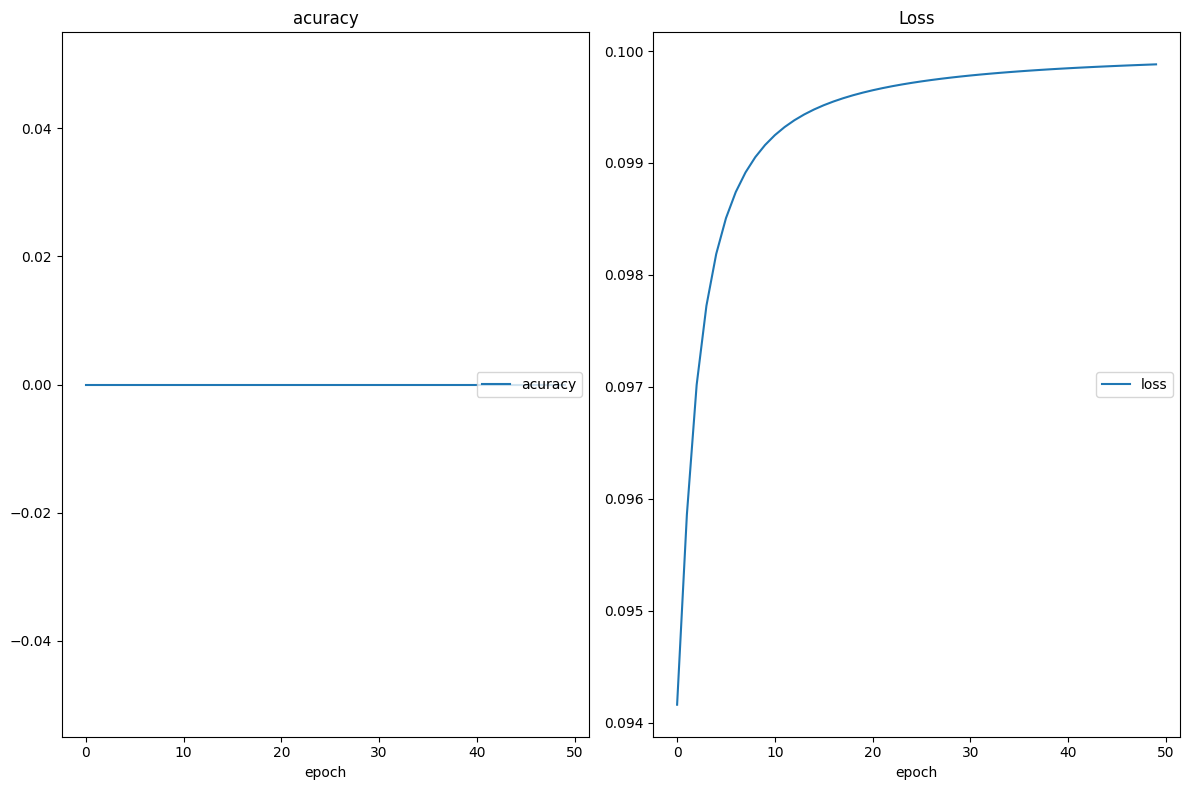

acuracy
	acuracy          	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	loss             	 (min:    0.094, max:    0.100, cur:    0.100)


In [ ]:
model.forward(train_loader, epochs=50)

In [ ]:
model.cmp(c_model)

layer Dense_h1, size: loc 2, par 2
layer Dense_h1, cmp False
layer Sigmoid_h1, size: loc 0, par 0
layer Sigmoid_h1, cmp True
layer Dense_h2, size: loc 2, par 2
layer Dense_h2, cmp False
layer Sigmoid_h2, size: loc 0, par 0
layer Sigmoid_h2, cmp True


False